In [1]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00


In [2]:
!pip install tensorflow keras

In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,MaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [4]:
df = pd.read_csv("politik_cleaned.csv")
df.head()

,full_text,label,text_clean
0,Atalia Dituding Perpanjang Dinasti Politik kar...,0,atalia dituding perpanjang dinasti politik kar...
1,Tahun Baru. Saya harap ahli politik tanahair d...,1,tahun baru saya harap ahli politik tanahair da...
2,Saya cukup ghibah politik. Sudah diurus banyak...,1,saya cukup ghibah politik sudah diurus banyak ...
3,Buka X skrg udah kaya masuk kelas FISIP ajg is...,1,buka x skrg udah kaya masuk kelas fisip ajg is...
4,Saya menjual NASIHAT UNTUK SBY ~ politik ~ huk...,1,saya menjual nasihat untuk sby politik hukum p...


In [5]:
df = df[["text_clean", "label"]]
df.rename(columns={"text_clean": "text", "label": "label"}, inplace=True)
# df.rename(columns={"Tweets": "text", "Label": "label"}, inplace=True)
# df["label"] = df["label"].map({"Hoax": 1, "Valid": 0})
df['label'] = df['label'].astype('int')
df.replace("", float("NaN"), inplace=True)
df.dropna(inplace=True)

df = df[['text', 'label']]

df.sample(5)

<ipython-input-5-012d123139f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"text_clean": "text", "label": "label"}, inplace=True)
<ipython-input-5-012d123139f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].astype('int')
<ipython-input-5-012d123139f9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace("", float("NaN"),

,text,label
1828,kayak gini emang bisa mas pikirkan atau sekali...,1
774,gue akuin pesta politik taun ini tuh random be...,1
1093,gue ga terlalu suka ngikutin politik tbh tp gu...,1
3657,pengamat politik ikrar nusa bhakti angkat bica...,0
1350,gue sbenernya deg2an si ngetweet atau post apa...,1


In [6]:
df.shape

(4263, 2)

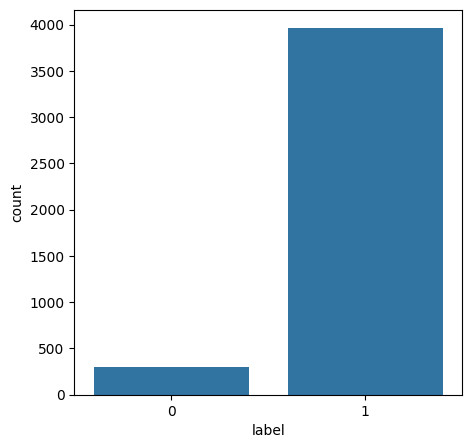

In [7]:
plt.figure(figsize=(5, 5))
ax = sns.countplot(x=df['label'])


# W2V


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Data
X = df['text']  # Kolom teks dari DataFrame
y = df['label']  # Kolom label dari DataFrame

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Batasi hingga 5000 fitur teratas
X_tfidf = vectorizer.fit_transform(X).toarray()  # Hasilkan matriks numerik

# Cek hasil
print("Shape of TF-IDF matrix:", X_tfidf.shape)  # Dimensi TF-IDF matrix
print("First document TF-IDF vector:", X_tfidf[0])  # Vektor TF-IDF dokumen pertama


Shape of TF-IDF matrix: (4263, 5000)
First document TF-IDF vector: [0. 0. 0. ... 0. 0. 0.]


In [9]:
y = np.array(y)

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

In [11]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

reports = []
confusions = []

for train_index, test_index in kf.split(X_tfidf):
    # Split data
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Model LSTM
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))  # Input layer sesuai dengan dimensi TF-IDF
    model.add(Dropout(0.3))  # Dropout untuk regularisasi
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Output layer untuk binary classification

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Training model
    model.fit(X_train, y_train, validation_split=0.3, epochs=6, batch_size=32, verbose=1)

    # Prediksi pada data uji
    y_pred = (model.predict(X_test) >= 0.5).astype("int")

    # Evaluasi
    reports.append(classification_report(y_test, y_pred, zero_division=0))
    confusions.append(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.9074 - loss: 0.4737 - val_accuracy: 0.8862 - val_loss: 0.3523
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9479 - loss: 0.1425 - val_accuracy: 0.8862 - val_loss: 0.3329
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9511 - loss: 0.1141 - val_accuracy: 0.8862 - val_loss: 0.3560
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9759 - loss: 0.0663 - val_accuracy: 0.8897 - val_loss: 0.4275
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9894 - loss: 0.0296 - val_accuracy: 0.8879 - val_loss: 0.5028
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9971 - loss: 0.0121 - val_accuracy: 0.8862 - val_loss: 0.5495
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9117 - loss: 0.4539 - val_accuracy: 0.8923 - val_loss: 0.3119
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9446 - loss: 0.1425 - val_accuracy: 0.8923 - val_loss: 0.2979
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9562 - loss: 0.0978 - val_accuracy: 0.8949 - val_loss: 0.3181
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9768 - loss: 0.0659 - val_accuracy: 0.8975 - val_loss: 0.4231
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9931 - loss: 0.0244 - val_accuracy: 0.8957 - val_loss: 0.4872
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9942 - loss: 0.0141 - val_accuracy: 0.8905 - val_loss: 0.5220
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9406 - loss: 0.4573 - val_accuracy: 0.8862 - val_loss: 0.3243
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9468 - loss: 0.1388 - val_accuracy: 0.8862 - val_loss: 0.3170
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9487 - loss: 0.0936 - val_accuracy: 0.8853 - val_loss: 0.3356
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9673 - loss: 0.0663 - val_accuracy: 0.8879 - val_loss: 0.3989
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9867 - loss: 0.0386 - val_accuracy: 0.8879 - val_loss: 0.4776
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9971 - loss: 0.0155 - val_accuracy: 0.8836 - val_loss: 0.5565
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8961 - loss: 0.4763 - val_accuracy: 0.8854 - val_loss: 0.3444
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9456 - loss: 0.1586 - val_accuracy: 0.8854 - val_loss: 0.3284
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9521 - loss: 0.0992 - val_accuracy: 0.8863 - val_loss: 0.3284
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9683 - loss: 0.0721 - val_accuracy: 0.8906 - val_loss: 0.3922
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9903 - loss: 0.0314 - val_accuracy: 0.8863 - val_loss: 0.4877
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9992 - loss: 0.0091 - val_accuracy: 0.8872 - val_loss: 0.5717
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9273 - loss: 0.4743 - val_accuracy: 0.8932 - val_loss: 0.3253
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9456 - loss: 0.1513 - val_accuracy: 0.8932 - val_loss: 0.3178
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9490 - loss: 0.1033 - val_accuracy: 0.8924 - val_loss: 0.3226
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9645 - loss: 0.0694 - val_accuracy: 0.8993 - val_loss: 0.3832
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0306 - val_accuracy: 0.8950 - val_loss: 0.4350
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0136 - val_accuracy: 0.8924 - val_loss: 0.5105
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9304 - loss: 0.4552 - val_accuracy: 0.8889 - val_loss: 0.3436
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9520 - loss: 0.1327 - val_accuracy: 0.8889 - val_loss: 0.3109
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9490 - loss: 0.1035 - val_accuracy: 0.8889 - val_loss: 0.3389
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9763 - loss: 0.0567 - val_accuracy: 0.8915 - val_loss: 0.3931
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9909 - loss: 0.0307 - val_accuracy: 0.8863 - val_loss: 0.4877
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0128 - val_accuracy: 0.8880 - val_loss: 0.5633
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9006 - loss: 0.4847 - val_accuracy: 0.8898 - val_loss: 0.3418
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9428 - loss: 0.1529 - val_accuracy: 0.8898 - val_loss: 0.3080
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9569 - loss: 0.0916 - val_accuracy: 0.8898 - val_loss: 0.3033
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9735 - loss: 0.0673 - val_accuracy: 0.8924 - val_loss: 0.4071
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9888 - loss: 0.0339 - val_accuracy: 0.8915 - val_loss: 0.4619
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0142 - val_accuracy: 0.8863 - val_loss: 0.5165
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9414 - loss: 0.4569 - val_accuracy: 0.8889 - val_loss: 0.3232
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9440 - loss: 0.1426 - val_accuracy: 0.8889 - val_loss: 0.3167
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9525 - loss: 0.0875 - val_accuracy: 0.8880 - val_loss: 0.3201
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9669 - loss: 0.0666 - val_accuracy: 0.8889 - val_loss: 0.3955
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0333 - val_accuracy: 0.8872 - val_loss: 0.4768
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9971 - loss: 0.0157 - val_accuracy: 0.8845 - val_loss: 0.5794
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9296 - loss: 0.4648 - val_accuracy: 0.8854 - val_loss: 0.3182
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9468 - loss: 0.1393 - val_accuracy: 0.8854 - val_loss: 0.3170
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9521 - loss: 0.0968 - val_accuracy: 0.8854 - val_loss: 0.3482
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9698 - loss: 0.0691 - val_accuracy: 0.8880 - val_loss: 0.3945
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0286 - val_accuracy: 0.8889 - val_loss: 0.5042
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0129 - val_accuracy: 0.8872 - val_loss: 0.5875
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9430 - loss: 0.4266 - val_accuracy: 0.8889 - val_loss: 0.3222
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9484 - loss: 0.1252 - val_accuracy: 0.8889 - val_loss: 0.3141
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9555 - loss: 0.0904 - val_accuracy: 0.8924 - val_loss: 0.3253
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0490 - val_accuracy: 0.8941 - val_loss: 0.4003
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0282 - val_accuracy: 0.8924 - val_loss: 0.4696
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0150 - val_accuracy: 0.8915 - val_loss: 0.5435
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=1, batch_size=32)  # Adjust epochs and batch size as needed

120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9679 - loss: 0.1403


In [13]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 128)                 │         640,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,945,349 (7.42 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,296,900 (4.95 MB)

In [14]:
#hasil
for i in range (len(reports)):
  print(f"==========================={i+1}=============================")
  print("REPORT:")
  print(reports[i])

===========================1=============================
REPORT:
              precision    recall  f1-score   support

           0       0.60      0.29      0.39        31
           1       0.95      0.98      0.97       396

    accuracy                           0.93       427
   macro avg       0.77      0.64      0.68       427
weighted avg       0.92      0.93      0.92       427

===========================2=============================
REPORT:
              precision    recall  f1-score   support

           0       0.43      0.19      0.26        32
           1       0.94      0.98      0.96       395

    accuracy                           0.92       427
   macro avg       0.68      0.58      0.61       427
weighted avg       0.90      0.92      0.91       427

===========================3=============================
REPORT:
              precision    recall  f1-score   support

           0       0.57      0.29      0.38        28
           1       0.95      0.98      

In [15]:
def report(matrix):
  TP = matrix[1][1]
  TN = matrix[0][0]
  FP = matrix[1][0]
  FN = matrix[0][1]

  accuracy = (TP+TN)/(TP+FP+FN+TN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  errorRate = (FP+FN)/(TP+FP+FN+TN)
  f1 = 2*TP / (2*TP + FP + FN)

  print(f"Accuracy = {accuracy}")
  print(f"Precision = {precision}")
  print(f"Recall = {recall}")
  print(f"Error Rate = {errorRate}")
  print(f"f1-score = {f1}")

In [16]:
result = [[ 0,   0],[  0, 0],]

for i in range (len(confusions)):
  result = result + confusions[i]


In [17]:
print(f"Overall Performance")
report(result)

Overall Performance
Accuracy = 0.9340839784189537
Precision = 0.9871309613928841
Recall = 0.9444712699179141
Error Rate = 0.06591602158104622
f1-score = 0.9653300431832202
